# Tools for iterative ptychography
This notebook showcases how to use the tools for fast iterative ptychography in `ptychography40.reconstruction.common`. 

First, a forward simulation is performed. The diffraction pattern and the object are then transformed individually to different coordinate systems to reflect the typical situation in real measurements where coodinates are not matched pixel-by-pixel, but defined by experimental geometry and settings. 

After that, the transformed detector data is compared with a forward model in a way that is typical for iterative ptychography implementations. A method based on the tools in `ptychography40.reconstruction.common` is benchmarked against a simple reference implementation based on `scipy.ndimage` and NumPy.

In [1]:
%matplotlib nbagg
#%load_ext line_profiler

In [2]:
import numpy as np
import scipy.ndimage

import matplotlib.pyplot as plt

In [3]:
from ptychography40.reconstruction.common import (
    wavelength, diffraction_to_detector, image_transformation_matrix, apply_matrix,
    fftshift_coords, ifftshift_coords, rolled_object_probe_product_cpu
)

## Define parameters for the initial simulation

Instead of measured data we use a simulation that is better suited to verify the calculation.

In [4]:
size = 256
semiconv = 0.020  # radian
lmbda = wavelength(300)  # 300 kV
pixel_size_real_sim = 0.5 * lmbda  # Simulate at high resolution
# One pixel in the diffracted space corresponds to the entire size in real space.
pixel_size_detector_sim = 1/size/pixel_size_real_sim*lmbda

In [5]:
lmbda, pixel_size_real_sim, pixel_size_detector_sim

(1.9687489006848795e-12, 9.843744503424398e-13, 0.0078125)

## Create an object

This object has low symmetry and contains a wave modulation, which leaves a characteristic signature in the diffraction pattern.

In [6]:
obj = np.ones((size, size), dtype=np.complex64)
y, x = np.ogrid[-size//2:size//2, -size//2:size//2]

outline = (((y*1.2)**2 + x**2) > 110**2) & ((((y*1.2)**2 + x**2) < 120**2))
obj[outline] = 0

left_eye = ((y + 40)**2 + (x + 40)**2) < 20**2
obj[left_eye] = 0
right_eye = (np.abs(y + 40) < 15) & (np.abs(x - 40) < 30)
obj[right_eye] = 0

nose = (y + 20 + x > 0) & (x < 0) & (y < 10)

obj[nose] = (0.05j * x + 0.05j * y)[nose]

mouth = (((y*1)**2 + x**2) > 50**2) & ((((y*1)**2 + x**2) < 70**2)) & (y > 20)

obj[mouth] = 0

tongue = (((y - 50)**2 + (x - 50)**2) < 20**2) & ((y**2 + x**2) > 70**2)
obj[tongue] = 0

# This wave modulation introduces a strong signature in the diffraction pattern
# that allows to confirm the correct scale and orientation.
signature_wave = np.exp(1j*(3 * y + 7 * x) * 2*np.pi/size)

obj += 0.3*signature_wave - 0.3

<IPython.core.display.Javascript object>


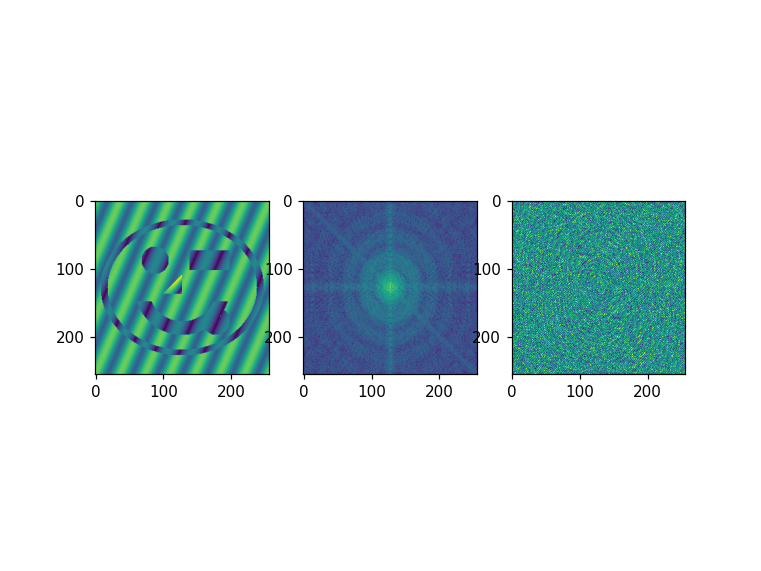

In [7]:
fig, axes = plt.subplots(1, 3)
axes[0].imshow(np.abs(obj))
axes[1].imshow(np.log1p(np.abs(np.fft.fftshift(np.fft.fft2(obj)))))
axes[2].imshow(np.angle(np.fft.fftshift(np.fft.fft2(obj))))

## Calculate the illumination

The illumination is first defined in radial space with a circular aperture, i.e. a convergent beam, as it is common in scanning transmission electron microscopy. It is then projected into the object plane using an inverse Fourier transform.

The `fftshift` takes care of proper shift to the center.

In [8]:
illum_radial = np.zeros((size, size))
illum_radial[np.sqrt(y**2 + x**2) * pixel_size_detector_sim <= semiconv] = 1

In [9]:
illum = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(illum_radial)))

<IPython.core.display.Javascript object>


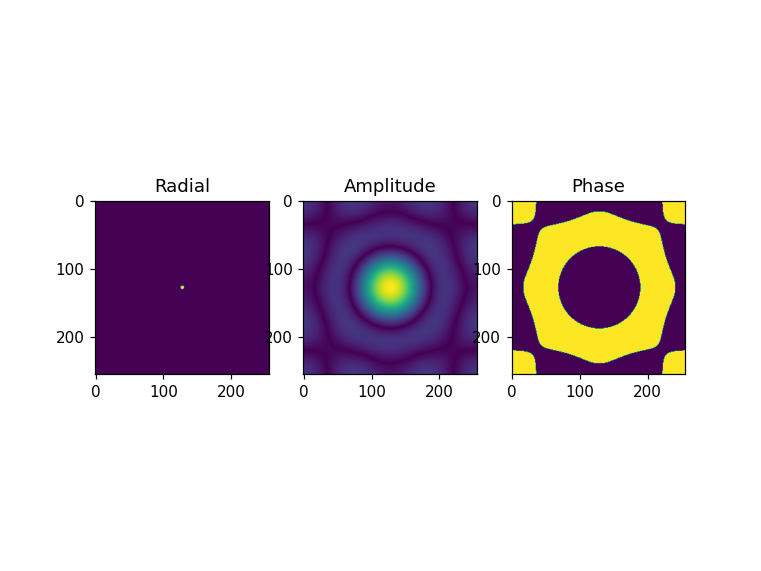

Text(0.5, 1.0, 'Phase')

In [10]:
fig, axes = plt.subplots(1, 3)
axes[0].imshow(illum_radial)
axes[0].set_title("Radial")
axes[1].imshow(np.abs(illum))
axes[1].set_title("Amplitude")
axes[2].imshow(np.angle(illum))
axes[2].set_title("Phase")

## Forward simulation

Multiply the illumination with the object, project it to the far field and transform amplitude to intensity.

In [11]:
exitwave = illum * obj
projection = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(exitwave)))
diffpattern_sim = np.abs(projection)**2

<IPython.core.display.Javascript object>


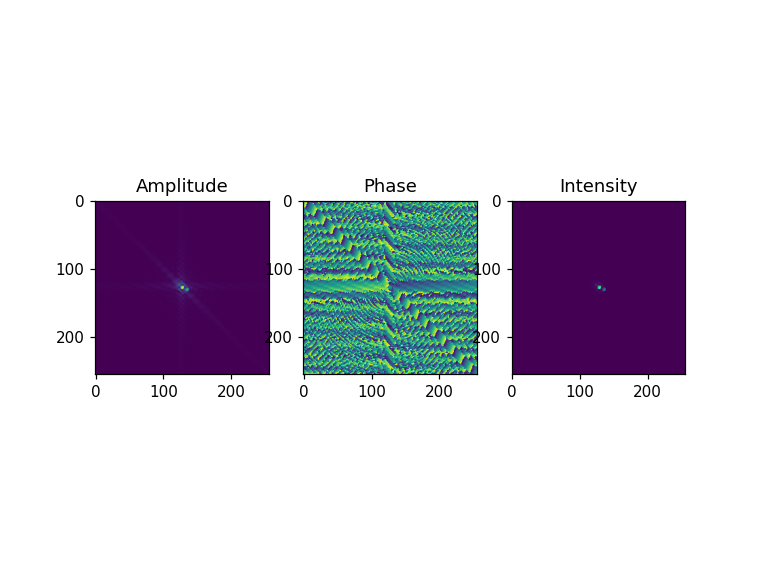

Text(0.5, 1.0, 'Intensity')

In [12]:
fig, axes = plt.subplots(1, 3)
axes[0].imshow(np.abs(projection))
axes[0].set_title("Amplitude")
axes[1].imshow(np.angle(projection))
axes[1].set_title("Phase")
axes[2].imshow(diffpattern_sim)
axes[2].set_title("Intensity")

## Transform the "perfect" simulation to a typical experimental result

The data is resampled with user-defined pixel sizes that are mismatched between object and diffraction pattern.

Furthermore, the diffraction pattern is rotated and shifted. In real experiments the rotation is usually close to 90 ° increments, but electron microscopes can also include a free rotation in their projection. The detector data might also be mirrored along an axis, i.e. be recorded with different handedness than the object coordinates. This is not shown here for simplicity.

In [13]:
pixel_size_real = 10e-12  # m
pixel_size_detector = 0.001  # radian
scan_rotation = 65  # degrees
shift = (7, 3)

In [14]:
# Transform both object and illumination.
rec_obj = scipy.ndimage.zoom(obj, pixel_size_real_sim/pixel_size_real)
rec_illum = scipy.ndimage.zoom(illum, pixel_size_real_sim/pixel_size_real)


# Step-by-step transformation of the diffraction pattern.
real_diffpattern = scipy.ndimage.zoom(diffpattern_sim, pixel_size_detector_sim/pixel_size_detector)
# Positive angle means counter-clockwise in scipy.ndimage.rotate by default
# Note that this implies a left-handed coordinate system in scipy.ndimage, different from the convention in LiberTEM
# that is right-handed. See also https://libertem.github.io/LiberTEM/concepts.html#coordinate-system.
# That means by using the positive scan rotation both here and later in creating the transformation matrix,
# the matrix undoes the rotation introduced here.
real_diffpattern = scipy.ndimage.rotate(real_diffpattern, scan_rotation, reshape=False)
real_diffpattern = scipy.ndimage.shift(real_diffpattern, shift)
center = real_diffpattern.shape[0] // 2
# Crop
real_diffpattern = real_diffpattern[center-64:center+65, center-64:center+65]
# Truncate negative values from interpolation
real_diffpattern = np.maximum(real_diffpattern, 0)

## Show mismatch between detector and forward model

A forward model multiplies the rescaled object with the rescaled illumination, project the resulting exit wave into the far field and compares the wave with the detector data. Here we see that this is not possible anymore pixel-by-pixel since the object and detector data underwent different, incompatible transformations.

In [15]:
# Project illumination into the far field: "zero order beam"
rec_illum_radial = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(rec_illum)))

<IPython.core.display.Javascript object>


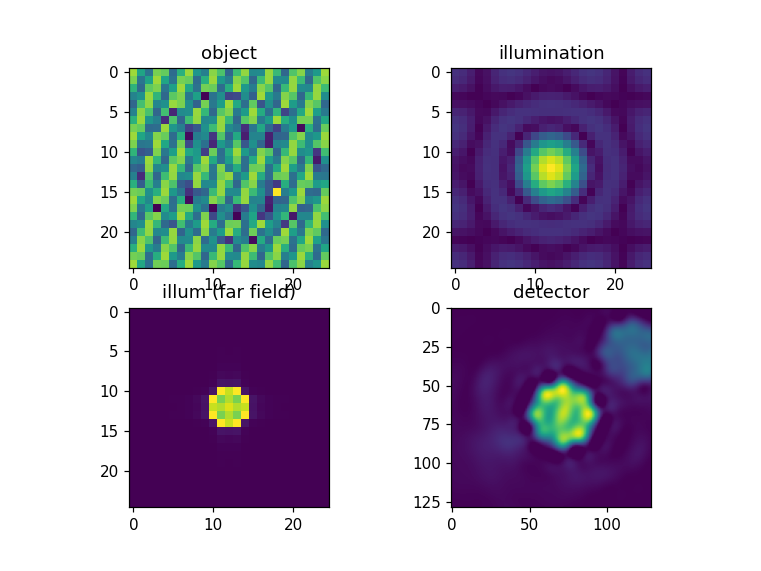

Text(0.5, 1.0, 'detector')

In [16]:
fig, axes = plt.subplots(2, 2)
axes[0, 0].imshow(np.abs(rec_obj))
axes[0, 0].set_title("object")
axes[0, 1].imshow(np.abs(rec_illum))
axes[0, 1].set_title("illumination")
axes[1, 0].imshow(np.abs(rec_illum_radial))
axes[1, 0].set_title("illum (far field)")
axes[1, 1].imshow(np.log1p(real_diffpattern))
axes[1, 1].set_title("detector")

## Forward models

Here we define a reference forward model and compare it with an optimized implementation based on the functions in `ptychography40.reconstruction.common`.

The optimized implementation avoids several copies of the data since `rolled_object_probe_product_cpu()` folds rolling, product and inverse FFT shift into a single operation. Furthermore, it can process a whole stack of shifts in one go, which reduces overheads for small illuminated areas. Note that the fast implementation omits the last FFT shift. This is performed later on the detector data instead.

`rolled_object_probe_product_cpu()` also supports illuminations that are smaller than the object to improve the scaling behavior with large objects and small illuminated area. Furthermore it can perform subpixel shifts if an array of subpixel-shifted illuminations is provided. Those features are not demonstrated here.

In [17]:
def reference_forward_model(illum, obj, shifts):
    result = np.empty((len(shifts), *illum.shape), dtype=np.float32)
    for i, shift in enumerate(shifts):
        tmp_obj = np.roll(obj, -np.array(shift), axis=(0, 1))
        result[i] = np.abs(np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(illum * tmp_obj))))**2
    return result

In [18]:
def fast_forward_model(illum, obj, shifts):
    fast_forward_buffer = np.empty((len(shifts), *illum.shape), dtype=np.complex64)
    rolled_object_probe_product_cpu(
        obj=obj,
        probe=illum[np.newaxis, np.newaxis, ...],
        shifts=np.array(shifts),
        result_out=fast_forward_buffer,
        ifftshift=True
    )
    return np.abs(np.fft.fft2(fast_forward_buffer))**2

In [19]:
ref = reference_forward_model(rec_illum, rec_obj, [(0, 0), (3, 4)])
fast = fast_forward_model(rec_illum, rec_obj, [(0, 0),(3, 4)])

In [20]:
np.allclose(np.fft.fftshift(fast, axes=(1, 2)), ref)

True

<IPython.core.display.Javascript object>


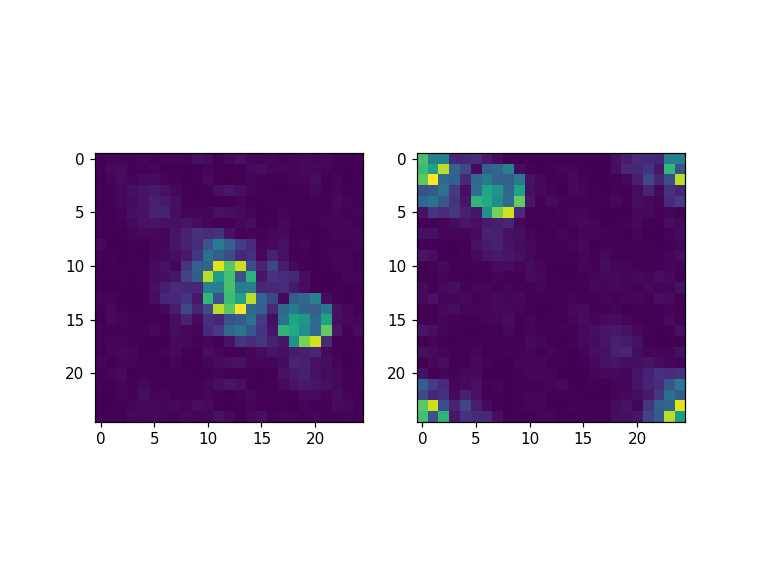

In [21]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(np.real(ref[1]))
axes[1].imshow(np.real(fast[1]))

## Transformation of the detector data

The detector data has to be transformed in such a way that it matches the forward model. That way, an update function for the object and/or illumination can be computed from a comparison of both.

Again, we compare two methods: A reference method that uses `scipy.ndimage` to unwind the transformations that have been applied to the simulated pattern and scale it to the correct resolution, and a faster method using functions from `ptychography40.reconstruction.common` that calculates and applies a sparse transformation matrix.

Once the matrix is pre-computed, this method can apply all transformations in a single step to a whole stack of images. Furthermore, it can perform an inverse FFT shift with zero overhead to avoid this step in the forward model calculation.

Please note that both transformation methods are lossy and give somewhat different results.

In [22]:
def reference_tansform(diffpatterns, target_shape):
    pixel_size_detector_reconstruction = 1/target_shape[0]/pixel_size_real*lmbda
    matched_patterns = np.empty((len(diffpatterns), *target_shape))
    zoom = pixel_size_detector/pixel_size_detector_reconstruction
    # We apply the ndimage transformations step by step since the 3D version
    # to process a stack is slower
    for i in range(len(diffpatterns)):
        matched_diffpattern = scipy.ndimage.shift(diffpatterns[i], (-shift[0], -shift[1]))
        matched_diffpattern = scipy.ndimage.rotate(matched_diffpattern, -scan_rotation, reshape=True)
        matched_diffpattern = scipy.ndimage.zoom(matched_diffpattern, zoom)
        padding = (target_shape[0] - matched_diffpattern.shape[0]) / 2
        padding_spec = ((int(np.floor(padding)), int(np.ceil(padding))), )*2
        matched_patterns[i] = np.pad(matched_diffpattern, pad_width=padding_spec)
    return matched_patterns

The fast method first defines coordinate transformations, then calculates a sparse transformation matrix from these coordinate transformations, and finally applies them to data. This is particularly efficient to process a large number of images with the same transformation, as required for ptychography.

In [23]:

affine_transformation = diffraction_to_detector(
    lamb=lmbda,
    diffraction_shape=rec_obj.shape,
    pixel_size_real=pixel_size_real,
    pixel_size_detector=pixel_size_detector,
    cy=real_diffpattern.shape[0]/2 + shift[0],
    cx=real_diffpattern.shape[1]/2 + shift[1],
    flip_y=False,
    scan_rotation=scan_rotation
)

def pre_transform(coords):
    return ifftshift_coords(coords, reconstruct_shape=rec_obj.shape)

transformation_fast = image_transformation_matrix(
    source_shape=real_diffpattern.shape,
    target_shape=rec_obj.shape,
    affine_transformation=affine_transformation,
    pre_transform=pre_transform,
)

In [24]:
transformed_reference = reference_tansform(
    real_diffpattern[np.newaxis, ...],
    rec_obj.shape
)[0]

transformed_fast = apply_matrix(
    sources=real_diffpattern[np.newaxis, ...],
    matrix=transformation_fast,
    target_shape=rec_obj.shape
)[0]

## Verify match

Forward model and transformed detector data should be similar.

<IPython.core.display.Javascript object>


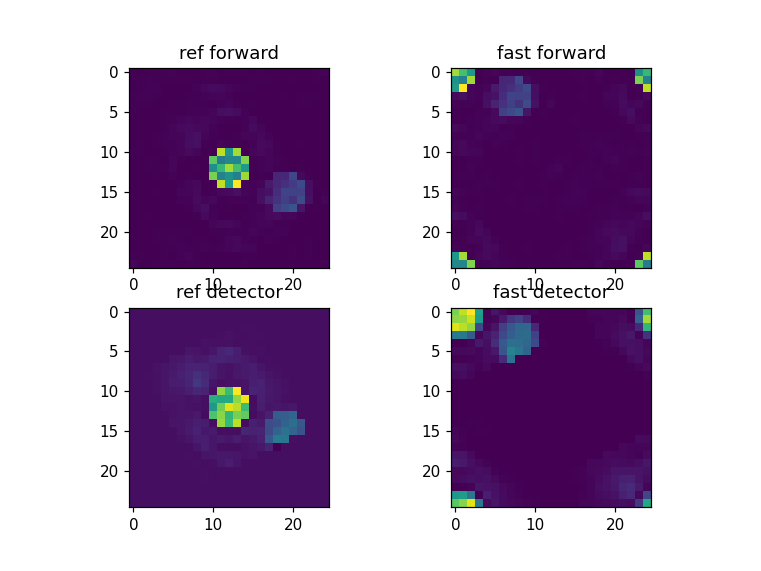

Text(0.5, 1.0, 'fast detector')

In [25]:
fig, axes = plt.subplots(2, 2)
axes[0, 0].imshow((reference_forward_model(rec_illum, rec_obj, [(0, 0)])[0]))
axes[0, 0].set_title("ref forward")
axes[0, 1].imshow((fast_forward_model(rec_illum, rec_obj, [(0, 0)])[0]))
axes[0, 1].set_title("fast forward")
axes[1, 0].imshow((transformed_reference))
axes[1, 0].set_title("ref detector")
axes[1, 1].imshow((transformed_fast))
axes[1, 1].set_title("fast detector")

## Compare performance

The method based on `ptychography40.reconstruction.common` is about 70x faster.

In [26]:
def compare_ref(illum, obj, diffpatterns, probe_shifts):
    matched_patterns = reference_tansform(diffpatterns, obj.shape)
    ref_diff = matched_patterns - reference_forward_model(illum, obj, probe_shifts)
    return ref_diff

In [27]:
def compare_fast(illum, obj, diffpatterns, probe_shifts,  transformation):
    transformed_fast = apply_matrix(
        sources=diffpatterns,
        matrix=transformation,
        target_shape=obj.shape
    )
    fast_diff = transformed_fast - fast_forward_model(illum, obj, probe_shifts)
    return fast_diff

In [28]:
diffpattern_stack = np.stack((real_diffpattern, )* 32)
shifts = np.array([(i, i) for i in range(32)])

In [29]:
%%timeit
compare_ref(rec_illum, rec_obj, diffpattern_stack, shifts)

167 ms ± 2.56 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [30]:
%%timeit
compare_fast(rec_illum, rec_obj, diffpattern_stack, shifts, transformation_fast)

2.53 ms ± 24.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [31]:
# %lprun -f compare_ref -f reference_tansform -f reference_forward_model compare_ref(rec_illum, rec_obj, diffpattern_stack, shifts)

In [32]:
# %lprun -f compare_fast compare_fast(rec_illum, rec_obj, diffpattern_stack, shifts, transformation_fast)

## Conclusion

Besides being a lot faster, the tools in `ptychography40.reconstruction.common` accept parameters that are usually available from experiments, as opposed to requiring custom transformations. They are verified to behave the same as the SSB implementation and center of mass analysis in LiberTEM to facilitate compatible metadata across experimental modalities and reconstruction algorithms.

Tools to performing the "heavy lifting" in a consistent and performant way should make the implementation of ptychographic reconstruction methods easier and allow code re-use.